In [1]:
!pwd

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 w

### Training of BLIP on Path-VQA

Importing all relevant packages

In [4]:
from datasets import load_dataset
import torch
import io
import pickle
import pandas as pd
from transformers import BlipProcessor, BlipForQuestionAnswering
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image

Preparing data for peft tuning with lora

In [5]:
# Load the dataset
dataset = load_dataset("flaviagiammarino/path-vqa")

# Custom dataset class
class VQADataset(torch.utils.data.Dataset):
    """VQA dataset."""

    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get question and answer
        question = self.dataframe.iloc[idx]['question']
        answer = self.dataframe.iloc[idx]['answer']
        image_bytes = self.dataframe.iloc[idx]['image']['bytes']
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

        # Process the image and question
        encoding = self.processor(image, question, padding="max_length", truncation=True, return_tensors="pt")

        # Tokenize the answer
        labels = self.processor.tokenizer.encode(
            answer, max_length=8, padding="max_length", truncation=True, return_tensors='pt'
        )
        encoding["labels"] = labels
        encoding["attention_mask"] = encoding["attention_mask"]

        # Remove batch dimension
        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        return encoding

# Converting the dataset to pandas DataFrame
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()

# Filtering the yes/no questions
train_df = train_df[train_df['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)
val_df = val_df[val_df['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.29k [00:00<?, ?B/s]

(…)-00000-of-00007-f2d0e9ef9f022d38.parquet:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

(…)-00001-of-00007-47d8e0220bf6c933.parquet:   0%|          | 0.00/81.0M [00:00<?, ?B/s]

(…)-00002-of-00007-7fb5037c4c5da7be.parquet:   0%|          | 0.00/104M [00:00<?, ?B/s]

(…)-00003-of-00007-74b9b7b81cc55f90.parquet:   0%|          | 0.00/90.0M [00:00<?, ?B/s]

(…)-00004-of-00007-77eea90af4a55dce.parquet:   0%|          | 0.00/46.1M [00:00<?, ?B/s]

(…)-00005-of-00007-5332ec423be520bd.parquet:   0%|          | 0.00/55.8M [00:00<?, ?B/s]

(…)-00006-of-00007-637a58c700b604af.parquet:   0%|          | 0.00/57.3M [00:00<?, ?B/s]

(…)-00000-of-00003-90a5518d26493b67.parquet:   0%|          | 0.00/41.3M [00:00<?, ?B/s]

(…)-00001-of-00003-cbfe947a3418595c.parquet:   0%|          | 0.00/45.7M [00:00<?, ?B/s]

(…)-00002-of-00003-9ec816895bd3bc20.parquet:   0%|          | 0.00/64.7M [00:00<?, ?B/s]

(…)-00000-of-00003-e9adadb4799f44d3.parquet:   0%|          | 0.00/41.2M [00:00<?, ?B/s]

(…)-00001-of-00003-7ea98873fc919813.parquet:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

(…)-00002-of-00003-1628308435019820.parquet:   0%|          | 0.00/69.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19654 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6259 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6719 [00:00<?, ? examples/s]

In [6]:
from peft import LoraConfig,PrefixTuningConfig, get_peft_model
from transformers import BlipForQuestionAnswering, BlipProcessor

# Load BLIP model
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Extract the correct hidden dimension and attention heads from BLIP's config
text_hidden_size = model.config.text_config.hidden_size  # Correct way to get token embedding dimension
num_attention_heads = model.config.text_config.num_attention_heads  # Correct way to get attention heads
vocab_size = processor.tokenizer.vocab_size

#model.config.vocab_size = vocab_size

# Fix: Define `token_dim` and `num_attention_heads` explicitly
"""
peft_config = PrefixTuningConfig(
    task_type="SEQ_2_SEQ_LM",  # BLIP is a sequence-to-sequence model
    inference_mode=False,
    num_virtual_tokens=20,  # Trainable prefix tokens
    num_layers=12,  # Apply prefix tuning to all transformer layers
    token_dim=text_hidden_size,  # Extracted correctly from BLIP's text transformer config
    num_attention_heads=num_attention_heads  # Extracted from BLIP config
)
"""
peft_config = LoraConfig(
    r=16,  # Low-rank adaptation rank
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "value"],  # Apply LoRA only to attention layers
)
# Apply Prefix Tuning
model = get_peft_model(model, peft_config)

# Print trainable parameters
model.print_trainable_parameters()


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

trainable params: 2,359,296 || all params: 387,031,868 || trainable%: 0.6096


In [7]:
torch.cuda.empty_cache()
torch.manual_seed(42)

# Create dataset objects
train_dataset = VQADataset(dataframe=train_df, processor=processor)
valid_dataset = VQADataset(dataframe=val_df, processor=processor)

# Create DataLoaders
batch_size = 8  # Optimized for A100 GPU
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)



BlipConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Salesforce/blip-vqa-base",
  "architectures": [
    "BlipForQuestionAnswering"
  ],
  "image_text_hidden_size": 256,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "label_smoothing": 0.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "blip",
  "projection_dim": 512,
  "text_config": {
    "_attn_implementation_autoset": true,
    "initializer_factor": 1.0,
    "model_type": "blip_text_model",
    "num_attention_heads": 12
  },
  "torch_dtype": "float32",
  "transformers_version": "4.48.2",
  "vision_config": {
    "_attn_implementation_autoset": true,
    "dropout": 0.0,
    "initializer_factor": 1.0,
    "initializer_range": 0.02,
    "model_type": "blip_vision_model",
    "num_channels": 3
  }
}



In [8]:
# Training settings
num_epochs = 10
patience = 5
min_eval_loss = float("inf")
early_stopping_hook = 0
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()

    for batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}'):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_mask = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            attention_mask=attention_mask,
                            labels=labels)

        loss = outputs.loss
        epoch_loss += loss.item()
        optimizer.zero_grad()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    model.eval()
    eval_loss = 0

    for batch in tqdm(valid_dataloader, desc=f'Validating Epoch {epoch+1}'):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_mask = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            attention_mask=attention_mask,
                            labels=labels)

        loss = outputs.loss
        eval_loss += loss.item()

    print(f"Epoch {epoch+1} - Train Loss: {epoch_loss/len(train_dataloader):.4f} - Eval Loss: {eval_loss/len(valid_dataloader):.4f}")
    scheduler.step()

    # Save best model
    if eval_loss < min_eval_loss:
        #model.config.vocab_size = processor.tokenizer.vocab_size
        model.save_pretrained("/content/drive/MyDrive/NLP_Project/Project/blip-peft-tuned")
        print("Saved best peft-tuned model!")
        min_eval_loss = eval_loss
        early_stopping_hook = 0
    else:
        early_stopping_hook += 1
        if early_stopping_hook > patience:
            break


<ipython-input-8-f4d9fb0b2b0c>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Validating Epoch 1: 100%|██████████| 391/391 [01:47<00:00,  3.64it/s]


Epoch 1 - Train Loss: 6.9152 - Eval Loss: 6.2807
Saved best peft-tuned model!


Validating Epoch 2: 100%|██████████| 391/391 [01:47<00:00,  3.62it/s]


Epoch 2 - Train Loss: 6.2579 - Eval Loss: 6.2502
Saved best peft-tuned model!


Validating Epoch 3: 100%|██████████| 391/391 [01:47<00:00,  3.65it/s]


Epoch 3 - Train Loss: 6.2436 - Eval Loss: 6.2486
Saved best peft-tuned model!


Validating Epoch 4: 100%|██████████| 391/391 [01:47<00:00,  3.65it/s]


Epoch 4 - Train Loss: 6.2390 - Eval Loss: 6.2442
Saved best peft-tuned model!


Validating Epoch 5: 100%|██████████| 391/391 [01:47<00:00,  3.65it/s]


Epoch 5 - Train Loss: 6.2363 - Eval Loss: 6.2435
Saved best peft-tuned model!


Validating Epoch 6: 100%|██████████| 391/391 [01:47<00:00,  3.65it/s]


Epoch 6 - Train Loss: 6.2332 - Eval Loss: 6.2438


Validating Epoch 7: 100%|██████████| 391/391 [01:46<00:00,  3.66it/s]


Epoch 7 - Train Loss: 6.2306 - Eval Loss: 6.2438


Validating Epoch 8: 100%|██████████| 391/391 [01:47<00:00,  3.65it/s]


Epoch 8 - Train Loss: 6.2283 - Eval Loss: 6.2462


Validating Epoch 9: 100%|██████████| 391/391 [01:46<00:00,  3.66it/s]


Epoch 9 - Train Loss: 6.2261 - Eval Loss: 6.2463


Validating Epoch 10: 100%|██████████| 391/391 [01:48<00:00,  3.61it/s]

Epoch 10 - Train Loss: 6.2242 - Eval Loss: 6.2498


Traditional fine-tuning where the model parameters are updated

In [4]:
# Initialize model and processor
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Empty cache and set manual seed
torch.cuda.empty_cache()
torch.manual_seed(42)

# Creating datasets and dataloaders
train_dataset = VQADataset(dataframe=train_df, processor=processor)
valid_dataset = VQADataset(dataframe=val_df, processor=processor)

batch_size = 8 # Max batch size for one A100 with 40GB VRAM
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Defining optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

# Training settings
num_epochs = 10
patience = 5
min_eval_loss = float("inf")
early_stopping_hook = 0
tracking_information = []
scaler = torch.cuda.amp.GradScaler()

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for batch in tqdm(train_dataloader, desc='Training batch: ...'):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_mask = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            attention_mask=attention_mask,
                            labels=labels)

        loss = outputs.loss
        epoch_loss += loss.item()
        optimizer.zero_grad()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    model.eval()
    eval_loss = 0
    for batch in tqdm(valid_dataloader, desc='Validating batch: ...'):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_mask = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            attention_mask=attention_mask,
                            labels=labels)

        loss = outputs.loss
        eval_loss += loss.item()

    tracking_information.append((epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
    print("Epoch: {} - Training loss: {} - Eval Loss: {}".format(epoch+1, epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader)))
    scheduler.step()

    # saving model with lowest validation loss
    if eval_loss < min_eval_loss:
        model.save_pretrained("Model/blip-saved-model")
        print("Saved model to Model/blip-saved-model")
        min_eval_loss = eval_loss
        early_stopping_hook = 0
    else:
        early_stopping_hook += 1
        if early_stopping_hook > patience:
            break

# saving training information
pickle.dump(tracking_information, open("tracking_information.pkl", "wb"))
print("The finetuning process is done!")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

<ipython-input-4-535b16321fe5>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Validating batch: ...: 100%|██████████| 391/391 [01:41<00:00,  3.84it/s]


Epoch: 1 - Training loss: 0.61427441892276 - Eval Loss: 0.04909204424697134
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|██████████| 391/391 [01:41<00:00,  3.84it/s]


Epoch: 2 - Training loss: 0.047165110576256095 - Eval Loss: 0.04901298017406603
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|██████████| 391/391 [01:41<00:00,  3.84it/s]


Epoch: 3 - Training loss: 0.04078654713001961 - Eval Loss: 0.06381151169110351


Validating batch: ...: 100%|██████████| 391/391 [01:42<00:00,  3.83it/s]


Epoch: 4 - Training loss: 0.036319931875181365 - Eval Loss: 0.047894513544291875
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|██████████| 391/391 [01:41<00:00,  3.84it/s]


Epoch: 5 - Training loss: 0.03202340692051614 - Eval Loss: 0.0499745490995761


Validating batch: ...: 100%|██████████| 391/391 [01:41<00:00,  3.85it/s]


Epoch: 6 - Training loss: 0.028575137390614395 - Eval Loss: 0.05484487633041465


Validating batch: ...: 100%|██████████| 391/391 [01:41<00:00,  3.84it/s]


Epoch: 7 - Training loss: 0.02412125118854129 - Eval Loss: 0.07289230787756723


Validating batch: ...: 100%|██████████| 391/391 [01:42<00:00,  3.83it/s]


Epoch: 8 - Training loss: 0.0205995759995849 - Eval Loss: 0.06861940705182214


Validating batch: ...: 100%|██████████| 391/391 [01:41<00:00,  3.85it/s]


Epoch: 9 - Training loss: 0.018877127214554413 - Eval Loss: 0.07164519889113337


Validating batch: ...: 100%|██████████| 391/391 [01:41<00:00,  3.85it/s]

Epoch: 10 - Training loss: 0.017221224599693268 - Eval Loss: 0.07501551689392844
The finetuning process is done!


Plotting train and eval loss

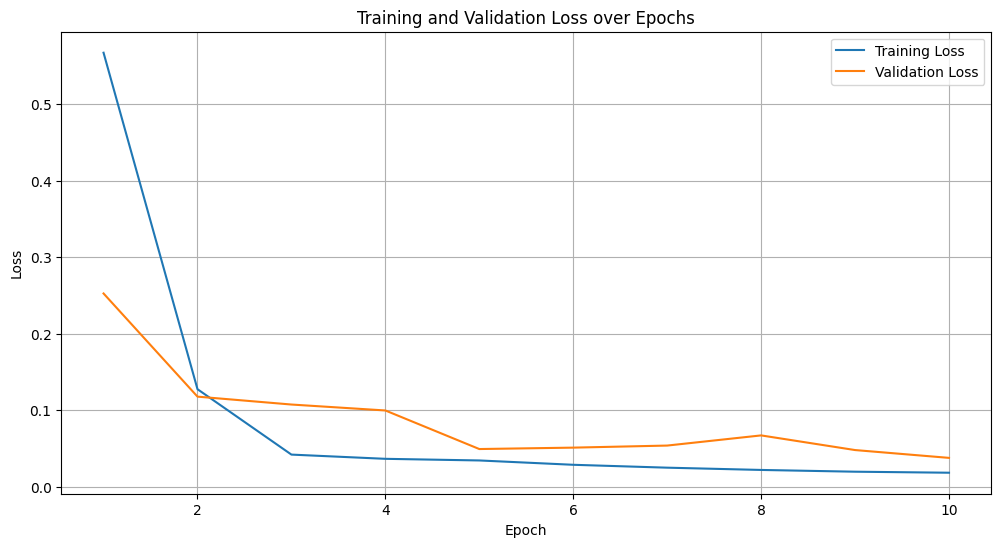

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Patho_VQA/final_tracking_information_10_e.csv")

# Extracting the training loss, validation loss, and learning rate
train_loss = df['train_loss']
val_loss = df['validation_loss']

# Plotting the training and validation loss with x-axis starting at 1
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Saving fine-tuned model

In [6]:
model.save_pretrained("Model/blip-saved-model_final")

### Inference on Path_VQA test set

Doing inference on Path_VQA test set using the latest model and writing predictions and labels into csv.

In [11]:
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import pandas as pd
import csv
import os
import torch
from tqdm import tqdm
from datasets import load_dataset
import io

# Initialize processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("/content/drive/MyDrive/NLP_Project/Project/blip-peft-tuned").to("cuda")

dataset = load_dataset("flaviagiammarino/path-vqa")

# Convert the test dataset to pandas DataFrame and filter yes/no answers
test_df = dataset['test'].to_pandas()
test_df = test_df[test_df['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)

# Create a list to store the results
results = []

# Iterate through each row in the test DataFrame
for idx, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Processing"):
    question = row['question']
    image_bytes = row['image']['bytes']
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    actual_answer = row['answer']

    # Prepare inputs
    encoding = processor(images=image, text=question, return_tensors="pt").to("cuda")

    # Perform inference
    out = model.generate(**encoding)
    generated_text = processor.decode(out[0], skip_special_tokens=True)

    # Append results using the index as the identifier
    results.append((idx, actual_answer, generated_text))

# Write the results to a CSV file
csv_file_path = "/content/drive/MyDrive/Patho_VQA/results_final_2.csv"
os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)
with open(csv_file_path, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["ID", "Actual Answer", "Generated Answer"])  # Write header
    csv_writer.writerows(results)

print(f"Results saved to {csv_file_path}")


Processing: 100%|██████████| 3362/3362 [06:35<00:00,  8.50it/s]

Results saved to /content/drive/MyDrive/Patho_VQA/results_final_2.csv


### Evaluation

Evaluating test on peft tuning

In [13]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(csv_file_path):
    # Load the CSV file
    results_df = pd.read_csv(csv_file_path)

    # Ensure the labels are consistent
    results_df['Actual Answer'] = results_df['Actual Answer'].str.strip().str.lower()
    results_df['Generated Answer'] = results_df['Generated Answer'].str.strip().str.lower()

    # Convert answers to binary labels
    actual_labels = results_df['Actual Answer'].apply(lambda x: 1 if x == 'yes' else 0)
    generated_labels = results_df['Generated Answer'].apply(lambda x: 1 if x == 'yes' else 0)

    # Calculate metrics
    accuracy = accuracy_score(actual_labels, generated_labels)
    precision = precision_score(actual_labels, generated_labels, zero_division=0)
    recall = recall_score(actual_labels, generated_labels, zero_division=0)
    f1 = f1_score(actual_labels, generated_labels, zero_division=0)

    return accuracy, precision, recall, f1

csv_file_path = "/content/drive/MyDrive/Patho_VQA/results_final_2.csv"
accuracy, precision, recall, f1 = calculate_metrics(csv_file_path)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8519
Precision: 0.8589
Recall: 0.8684
F1 Score: 0.8636


Evaluating BLIP without fine-tuning in this task

In [10]:
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import pandas as pd
import csv
import os
import torch
from tqdm import tqdm
from datasets import load_dataset
import io

# Initialize processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load dataset
dataset = load_dataset("flaviagiammarino/path-vqa")

# Convert the test dataset to pandas DataFrame and filter yes/no answers
test_df = dataset['test'].to_pandas()
test_df = test_df[test_df['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)

# Create a list to store the results
results = []

# Iterate through each row in the test DataFrame
for idx, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Processing"):
    question = row['question']
    image_bytes = row['image']['bytes']
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    actual_answer = row['answer']

    # Prepare inputs
    encoding = processor(images=image, text=question, return_tensors="pt").to(device)

    # Perform inference
    out = model.generate(**encoding)
    generated_text = processor.decode(out[0], skip_special_tokens=True)

    # Append results using the index as the identifier
    results.append((idx, actual_answer, generated_text))

# Write the results to a CSV file
csv_file_path = "results/results_no_finetuning.csv"
os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)
with open(csv_file_path, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["ID", "Actual Answer", "Generated Answer"])
    csv_writer.writerows(results)

print(f"Results saved to {csv_file_path}")

Processing: 100%|██████████| 3362/3362 [05:13<00:00, 10.73it/s]

Results saved to results/results_no_finetuning.csv


In [11]:
csv_file_path = "results/results_no_finetuning.csv"
accuracy, precision, recall, f1 = calculate_metrics(csv_file_path)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5161
Precision: 0.5342
Recall: 0.8122
F1 Score: 0.6445


### Results

The training significantly increased the capabilities of the base BLIP model in pathological visual question answering (yes/no questions).

After fine-tuning :

- Accuracy: 0.8519
- Precision: 0.8589
- Recall: 0.8684
- F1 Score: 0.8636

Before fine-tuning:

- Accuracy: 0.5164
- Precision: 0.5344
- Recall: 0.8122
- F1 Score: 0.6447

Overall improvements:

- Accuracy: 0.3355
- Precision: 0.3245
- Recall: 0.0562
- F1 Score: 0.2189


Pushing model to Hugging Face Hub

In [ ]:
from huggingface_hub import notebook_login

model = BlipForQuestionAnswering.from_pretrained("/content/Model/blip-saved-model_final")
notebook_login()
# Push the model to the Hugging Face Hub
model.push_to_hub("slinusc/path-vqa-blip")